<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Рандомный-лес" data-toc-modified-id="Рандомный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Рандомный лес</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

import time 
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df = df.set_index('datetime')
df.sort_index(inplace=True)

In [ ]:
df = df.resample('1H').sum()
print(df.index.is_monotonic)
df.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

<AxesSubplot:xlabel='datetime'>

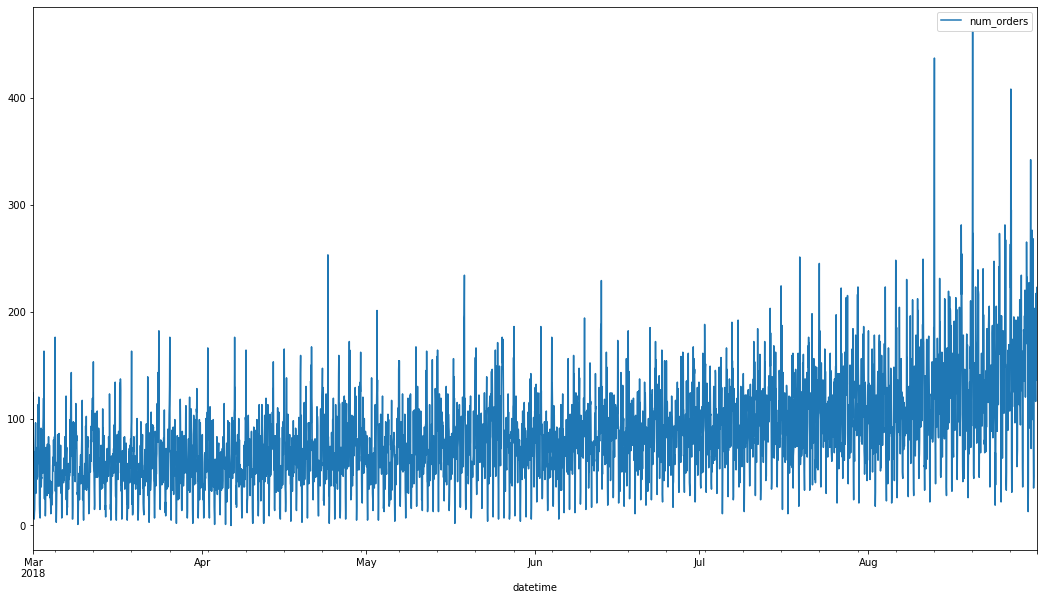

In [ ]:
data_resample = df.copy()
data_resample = data_resample.resample('1H').sum()
data_resample.plot(figsize=(18,10))

<AxesSubplot:xlabel='datetime'>

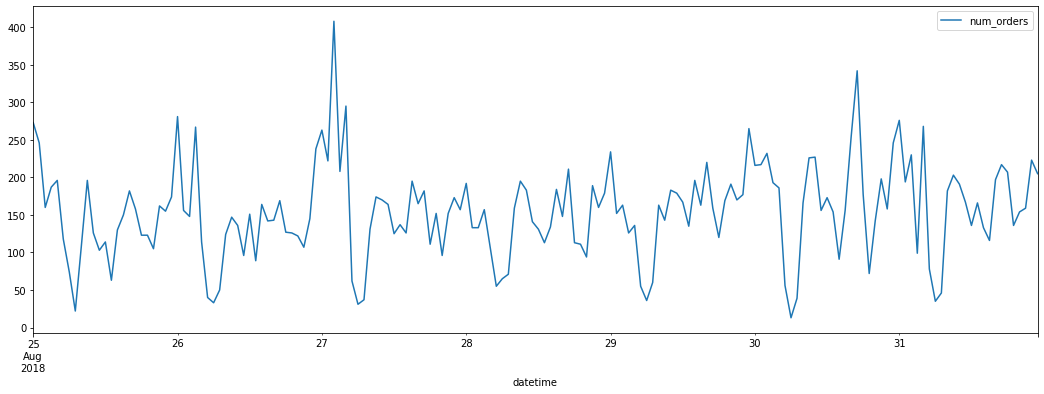

In [ ]:
data_resample['2018-08-25':'2018-08-31'].plot(figsize=(18,6))

<AxesSubplot:xlabel='datetime'>

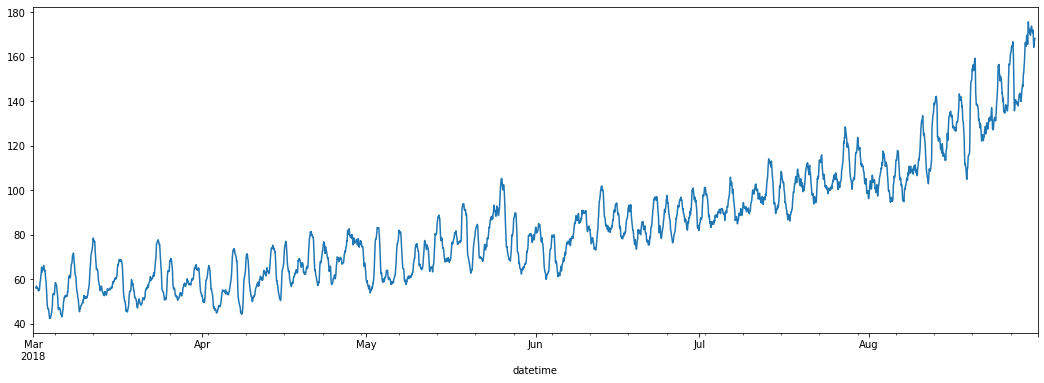

In [ ]:
decomposed_data_taxi = seasonal_decompose(data_resample)
decomposed_data_taxi.trend.plot(figsize=(18,6))

<AxesSubplot:xlabel='datetime'>

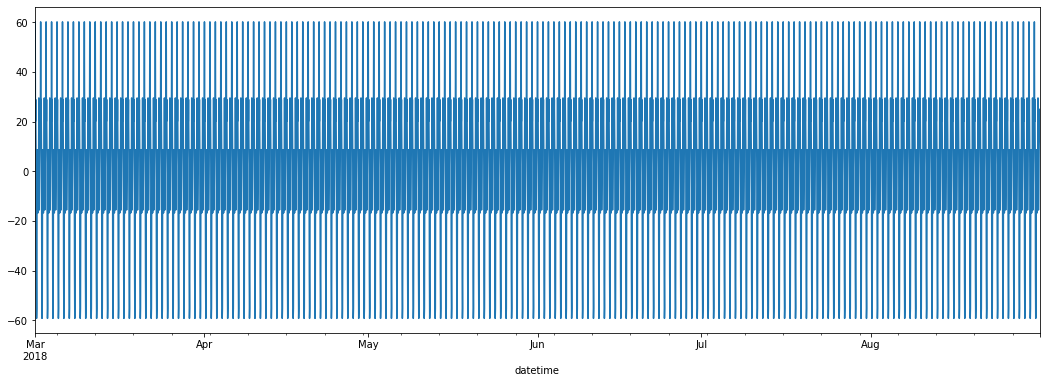

In [ ]:
decomposed_data_taxi.seasonal.plot(figsize=(18,6))

<AxesSubplot:xlabel='datetime'>

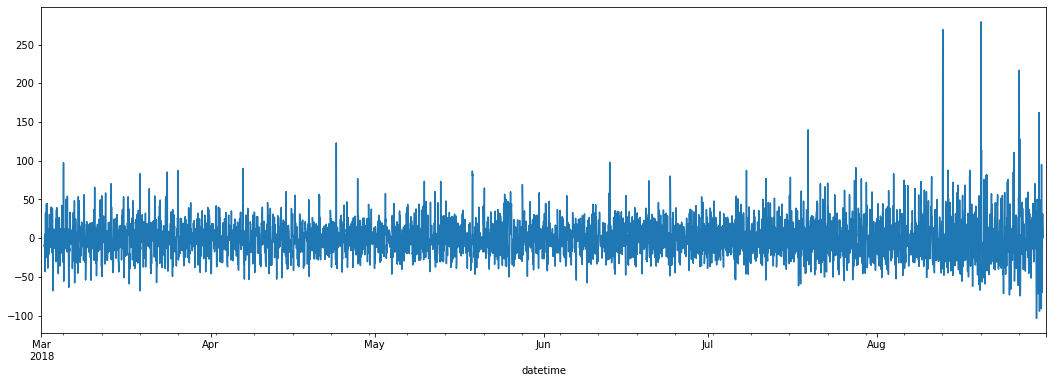

In [ ]:
decomposed_data_taxi.resid.plot(figsize=(18,6))

<AxesSubplot:title={'center':'сезонность'}, xlabel='datetime'>

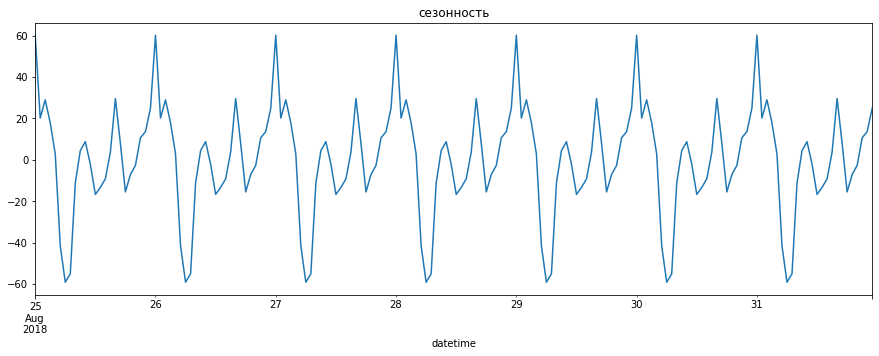

In [ ]:
decomposed_data_taxi.seasonal.tail(24*7).plot(title='сезонность', figsize=(15,5))

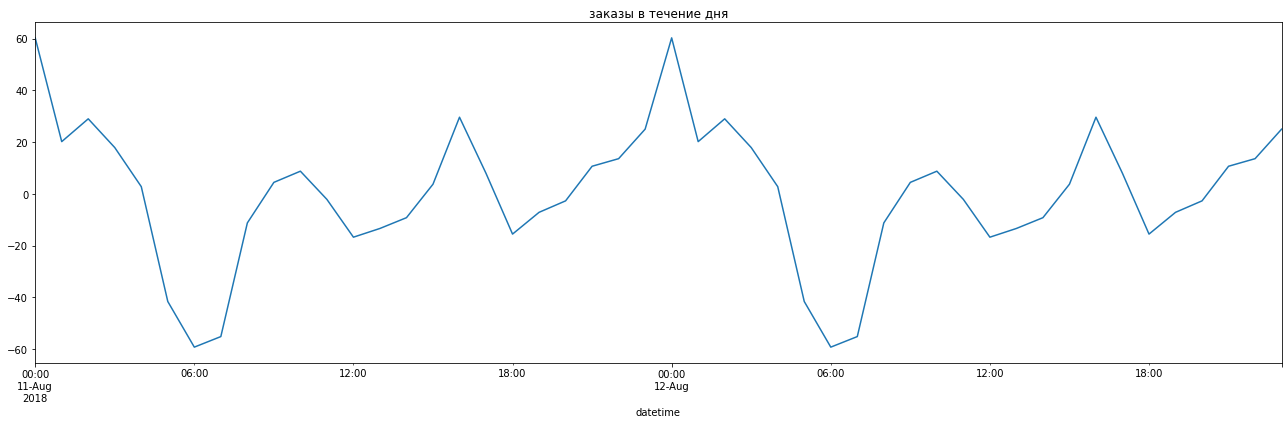

In [ ]:
plt.figure(figsize=(18, 6))
decomposed_data_taxi.seasonal['2018-08-11':'2018-08-12'].plot(ax=plt.gca())
plt.title('заказы в течение дня')
plt.tight_layout()

**Вывод**

- Дисперсия увеличичвается
- Тренд  растет, то есть кол-во заказов и пользователей растет
- Утром кол-во заказов резко падает


## Обучение

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(df, 10, 10)

In [ ]:
df

,num_orders,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,0,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,0,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,0,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,0,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,0,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,4,0,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,4,0,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


### Разделение данных

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [ ]:
print(train.shape)
print(test.shape)
print(features_train.shape)
print(features_test.shape)

(3964, 15)
(442, 15)
(3964, 14)
(442, 14)


In [ ]:
tscv = TimeSeriesSplit(n_splits=8)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target,parameters=None):
    if parameters:
        print(f'с параметрами: {parameters}')
    predicted_test = model.predict(test_features)
    predicted_train = model.predict(train_features)
    mse_test = mean_squared_error(test_target, predicted_test)
    mse_train = mean_squared_error(train_target, predicted_train)
    mape_test = mean_absolute_percentage_error(predicted_test, test_target)
    mape_train = mean_absolute_percentage_error(predicted_train, train_target)
    rmse_test = mse_test ** 0.5
    rmse_train = mse_train ** 0.5
    print(f'RMSE модели на тестовой выборке: {rmse_test}')
    print(f'RMSE модели на обучающей выборке: {rmse_train}')
    print(f'MAPE модели на тестовой выборке: {mape_test}')
    print(f'MAPE модели на обучающей выборке: {mape_train}')
    plotModelResults(model,train_features, train_target, test_features, test_target,True,False)
    print()

In [ ]:
def plotModelResults(model, X_train, Y_train ,X_test, Y_test,plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(Y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, Y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(Y_test))
            anomalies[Y_test<lower] = Y_test[Y_test<lower]
            anomalies[Y_test>upper] = Y_test[Y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, Y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [ ]:
random_state_val = 12345

### Линейная регрессия

In [ ]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

CPU times: user 6.32 ms, sys: 403 µs, total: 6.73 ms
Wall time: 4.67 ms


LinearRegression()

RMSE модели на тестовой выборке: 53.96247769484429
RMSE модели на обучающей выборке: 31.089003961872404
MAPE модели на тестовой выборке: 35.29151800494718
MAPE модели на обучающей выборке: 31.91831105785235



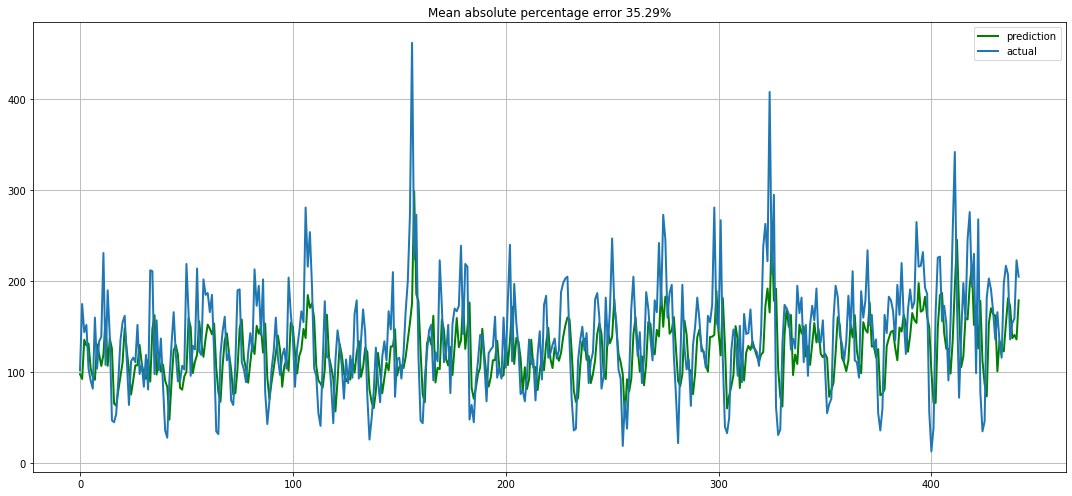

In [ ]:
evaluate_model(linear_model, features_train, target_train, features_test, target_test)

### Дерево решений 

In [ ]:
%%time
best_decision_tree_model = None
best_decision_tree_result = 100
best_decision_tree_depth = 0
best_decision_tree_leaf = 0
for depth in range(1,25):
    for leaf in range(1,25):
        model = DecisionTreeRegressor(random_state=random_state_val, max_depth=depth,min_samples_leaf=leaf)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_decision_tree_result > rmse:
            best_decision_tree_model = model
            best_decision_tree_result = rmse
            best_decision_tree_depth = depth
            best_decision_tree_leaf = leaf

CPU times: user 13.3 s, sys: 47.7 ms, total: 13.4 s
Wall time: 13.4 s


с параметрами: {'depth': 13, 'leaf': 6}
RMSE модели на тестовой выборке: 47.29538111509361
RMSE модели на обучающей выборке: 16.560055212099783
MAPE модели на тестовой выборке: 30.452564665141697
MAPE модели на обучающей выборке: 16.802976235059926



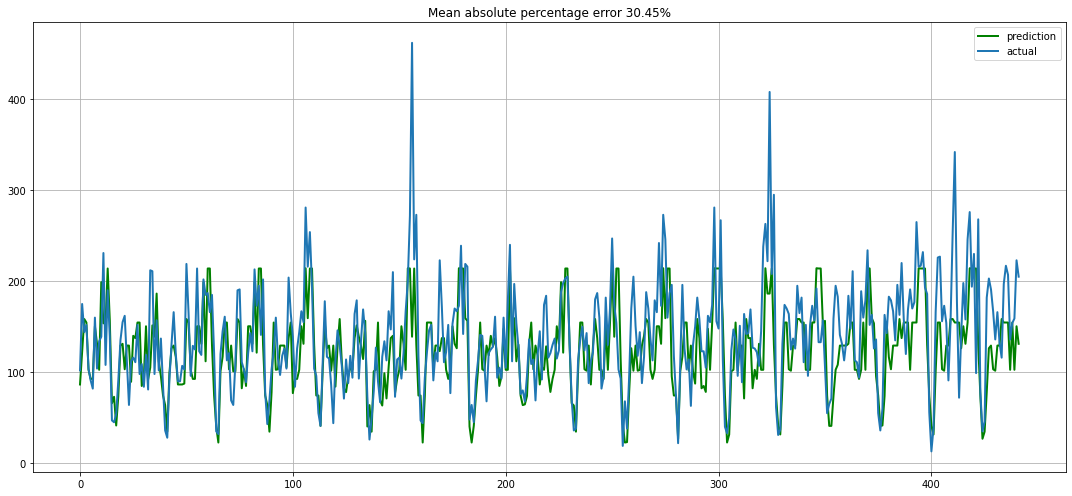

In [ ]:
evaluate_model(best_decision_tree_model, features_train, target_train, features_test, target_test, {'depth': best_decision_tree_depth, 'leaf': best_decision_tree_leaf})

### Рандомный лес

In [ ]:
%%time
best_randomforest_model = None
best_randomforest_result = 100
best_num_trees = 0
best_randomforest_depth = 0
for est in range(10,61,10):
    for depth in range(1,21):
        model = RandomForestRegressor(random_state=random_state_val, n_estimators=est,max_depth=depth)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_decision_tree_result > rmse:
            best_randomforest_model = model
            best_randomforest_result = rmse
            best_num_trees = est
            best_randomforest_depth = depth

CPU times: user 1min 9s, sys: 261 ms, total: 1min 9s
Wall time: 1min 9s


с параметрами: {'depth': 20, 'n_estimators': 60}
RMSE модели на тестовой выборке: 45.581156497078105
RMSE модели на обучающей выборке: 8.960716424200468
MAPE модели на тестовой выборке: 28.137668344207462
MAPE модели на обучающей выборке: 9.663891446917814



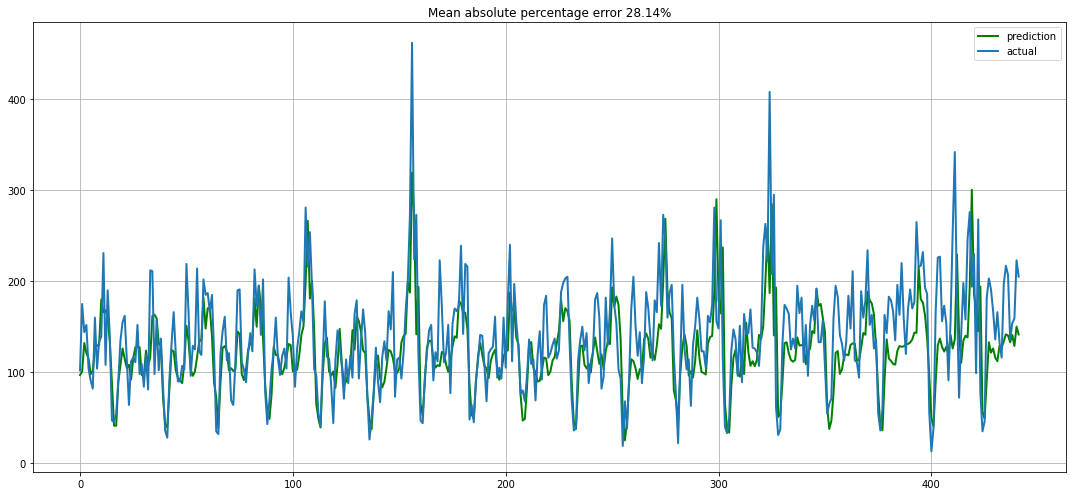

In [ ]:
evaluate_model(best_randomforest_model, features_train, target_train, features_test, target_test, {'depth': best_randomforest_depth, 'n_estimators': best_num_trees})

### XGBoost

In [ ]:
%%time
best_xgboost_model = None
best_xgboost_result = 100
best_xgboost_depth = 0
best_xgboost_estimators = 0
for depth in range(3,20,2):
    for estimators in range(1,24,2):
        model = xgb.XGBRegressor(n_jobs=-1,n_estimators=estimators,max_depth=depth) 
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_xgboost_result > rmse:
            best_xgboost_model = model
            best_xgboost_result = rmse
            best_xgboost_depth = depth
            best_xgboost_estimators = estimators

CPU times: user 9min 15s, sys: 3.59 s, total: 9min 18s
Wall time: 9min 23s


с параметрами: {'depth': 5, 'n_estimators': 21}
RMSE модели на тестовой выборке: 46.776995033320986
RMSE модели на обучающей выборке: 17.829666404533356
MAPE модели на тестовой выборке: 30.58536685810815
MAPE модели на обучающей выборке: 19.61591907698565



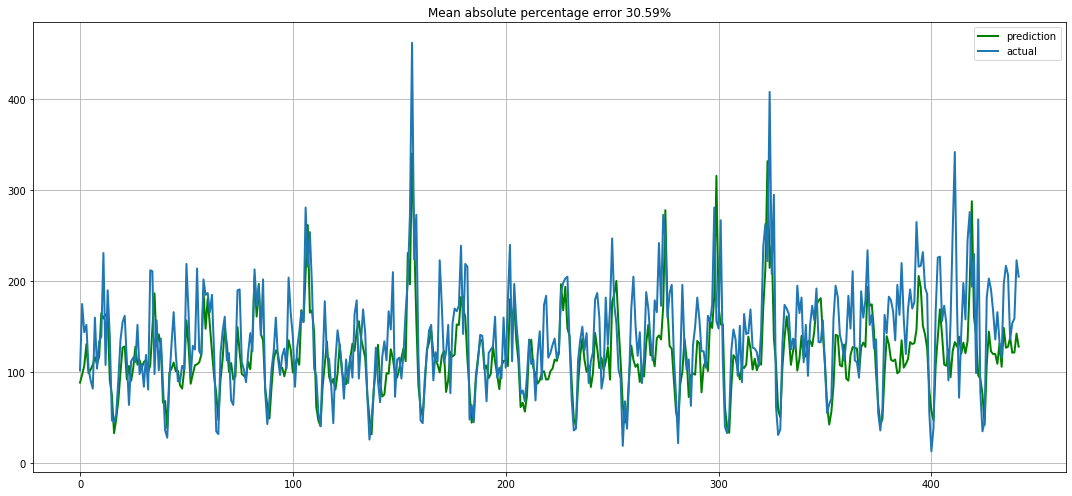

In [ ]:
evaluate_model(best_xgboost_model, features_train, target_train, features_test, target_test, {'depth': best_xgboost_depth, 'n_estimators': best_xgboost_estimators})

### LightGBM

In [ ]:
%%time
best_lightgbm_model = None
best_lightgbm_result = 100
best_lightgbm_objective = ''
best_lightgbm_boosting_type = ''
best_lightgbm_num_leaves = 0
best_lightgbm_max_depth = 0
for depth in [15, 20, 25, 30, 50]:
    for leaves in [10, 100, 200, 300]:
        for objective in ['regression','binary']:
            for boosting_type in ['dart', 'gbdt','goss']:
                model = lgb.LGBMRegressor(n_jobs=-1,boosting_type=boosting_type, num_leaves=leaves, max_depth=depth, objective=objective)
                model.fit(features_train, target_train)
                predicted_test = model.predict(features_test)
                mse = mean_squared_error(target_test, predicted_test)
                rmse = mse ** 0.5
                if best_lightgbm_result > rmse:
                    best_lightgbm_model = model
                    best_lightgbm_result = rmse
                    best_lightgbm_objective = objective
                    best_lightgbm_boosting_type = boosting_type
                    best_lightgbm_num_leaves = leaves
                    best_lightgbm_max_depth = depth

CPU times: user 3min 5s, sys: 1.29 s, total: 3min 7s
Wall time: 3min 9s


с параметрами: {'depth': 20, 'num_leaves': 200, 'objective': 'regression', 'boosting_type': 'goss'}
RMSE модели на тестовой выборке: 43.59962219161486
RMSE модели на обучающей выборке: 12.733914956908276
MAPE модели на тестовой выборке: 26.300206844110917
MAPE модели на обучающей выборке: 14.407734285351282



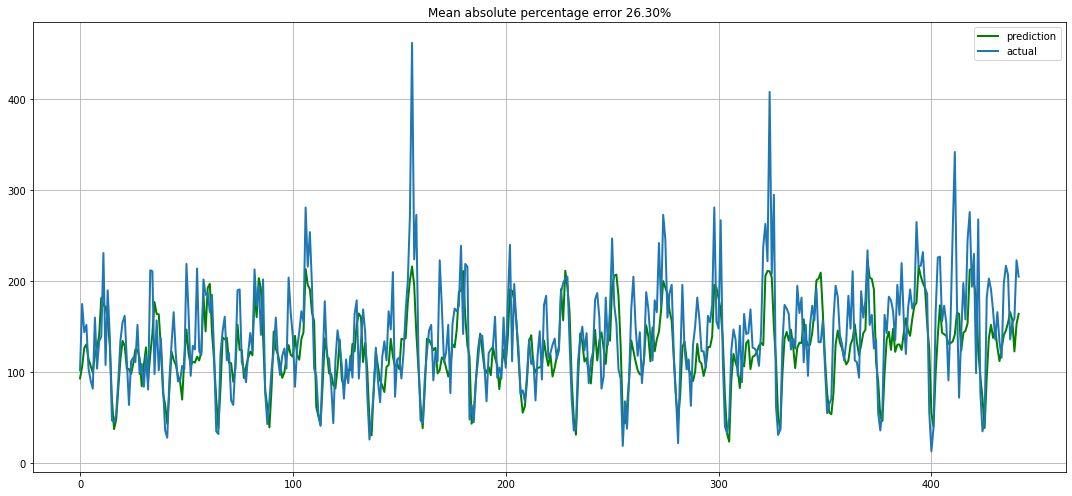

In [ ]:
evaluate_model(best_lightgbm_model, features_train, target_train, features_test, target_test, {'depth': best_lightgbm_max_depth,
                                                                                                           'num_leaves': best_lightgbm_num_leaves,
                                                                                                            'objective': best_lightgbm_objective,
                                                                                                            'boosting_type': best_lightgbm_boosting_type})

### CatBoost

In [ ]:
%%time
best_catboost_model = None
best_catboost_result = 100
best_catboost_l2_leaf_reg = 0
best_catboost_max_depth = 0
for depth in [5,10]:
    for l2_reg in [1,2,3]:
        model = CatBoostRegressor(loss_function='RMSE',random_state=random_state_val,silent=True,l2_leaf_reg=l2_reg, depth=depth)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_catboost_result > rmse:
            best_catboost_model = model
            best_catboost_result = rmse
            best_catboost_l2_leaf_reg = l2_reg
            best_catboost_max_depth = depth

CPU times: user 1min 15s, sys: 723 ms, total: 1min 16s
Wall time: 1min 21s


с параметрами: {'depth': 5, 'l2_leaf_reg': 1}
RMSE модели на тестовой выборке: 43.094912876941116
RMSE модели на обучающей выборке: 16.689281302361582
MAPE модели на тестовой выборке: 26.6159271025738
MAPE модели на обучающей выборке: 18.555272083849754



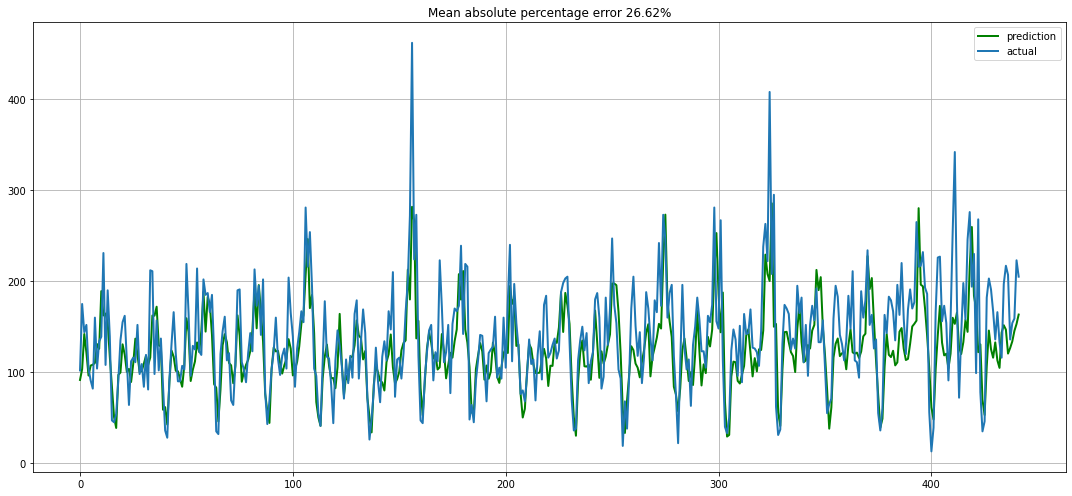

In [ ]:
evaluate_model(best_catboost_model, features_train, target_train, features_test, target_test, {'depth': best_catboost_max_depth,
                                                                                                           'l2_leaf_reg': best_catboost_l2_leaf_reg})

**Вывод**
* Был проведен анализ данных и подготовка данных для моделей
* Было проведено обучение разных моделей.
* На тестовых выборках лучшая модель  LGBMRegressor
* Еще я заметила разницу между тем, что когда обучаешь в разных средах разработки, то меняются показатели 